# Initialization

In [1]:
#!/usr/bin/python

__author__ = 'Elliot Simon'
__email__ = 'ellsim@dtu.dk'
__date__ = 'May 9, 2018'
__credits__ = ["DTU-Risø", "NCAR"]

In [164]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import datetime
import scipy
#import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics, preprocessing
import keras
import tensorflow as tf
import ipywidgets as widgets

In [3]:
from keras.models import Model, save_model, load_model, Sequential
from keras.layers import Reshape, Dense, Activation, Conv2D, Input, AveragePooling2D, MaxPooling2D, MaxPooling3D, Flatten, TimeDistributed, LSTM
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import EarlyStopping

In [4]:
print(keras.__version__)
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.2.0
1.8.0


SystemError: GPU device not found

In [5]:
%matplotlib inline

In [6]:
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Serif'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['savefig.transparent'] = True
plt.rcParams['image.cmap'] = 'hot_r'

In [ ]:
plt.rcParams.keys()

In [ ]:
# If we need to load data from google drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [10]:
# For google drive
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


# Functions

In [7]:
def rmse(x, y):
    return np.sqrt(metrics.mean_squared_error(x, y))

In [8]:
def pad_along_axis(array: np.ndarray, target_length, axis=0):
    pad_size = target_length - array.shape[axis]
    axis_nb = len(array.shape)
    if pad_size < 0:
        return a
    npad = [(0, 0) for x in range(axis_nb)]
    npad[axis] = (0, pad_size)
    b = np.pad(array, pad_width=npad, mode='constant', constant_values=0)
    return b

In [9]:
def calc_hspeed(u, v):
    '''Calculate horizontal wind speed (scalar) from u & v components'''
    hspeed = (np.sqrt(np.power(u, 2) + np.power(v, 2)))
    return hspeed

def calc_dir(u, v, offset=180):
    '''Calculate wind direction (degrees) from u and v components. Applies provided offset, default = 180 degrees'''
    direction = np.degrees(np.arctan2(v, u)) + offset
    return direction

In [10]:
def scatter(a,b,ll=0,ul=15):
    f = plt.figure(figsize=(8,8))
    plt.scatter(a,b)
    plt.xlim(ll,ul)
    plt.ylim(ll,ul)
    x = [ll, ul]
    y = [ll, ul]
    plt.plot(x,y, c='k')

In [11]:
def pers_metrics(a,b):
    scatter(a,b)
    e = rmse(a,b)
    print('RMSE = ' + str(np.round(e,4)))
    reg = sm.OLS(a, sm.add_constant(b)).fit()
    print(reg.summary())
    return e

In [161]:
def plot_preds(var=0, shift=0, ll=0, ul=15):
    if var == 0:
        var = 'wsp'
        df = df_spd
        title = 'Wind speed predictions'
    elif var == 1:
        ll=200
        ul=300
        var = 'wdir'
        df = df_dir
        title = 'Wind direction predictions'
    elif var == 2:
        var = 'u'
        df = df_u
        title = 'u-component predictions'
    elif var == 3:
        var = 'v'
        df = df_v
        title = 'v-component predictions'
        
    if shift == 1:
        scan = ' scan'
    else:
        scan = ' scans'
    
    #Scatter
    f1 = plt.figure(figsize=(8,8))
    plt.scatter(df_13s.iloc[1:len(preds)+shift+1][var].shift(shift).dropna(), df[shift].iloc[shift:])
    #plt.scatter(df_13s.iloc[1:len(preds)+shift+1][var].shift(shift).dropna(), df[shift])
    x = [ll, ul]
    y = [ll, ul]
    plt.plot(x,y, c='k')
    plt.xlim(ll,ul)
    plt.ylim(ll,ul)
    plt.title(title + ', leadtime = ' + str(shift) + scan + ' (' + str(np.round((shift*13)/60,2)) + ' mins)')

    #Time-series
    f2 = plt.figure()
    df_13s.iloc[1:len(preds)+shift+1][var].shift(shift).dropna().plot()
    df[shift].iloc[shift:].plot()
    plt.ylim(ll,ul)
    hfmt = DateFormatter('%H:%M:%S')
    plt.gca().xaxis.set_major_formatter(hfmt)
    plt.title(title + ', leadtime = ' + str(shift) + scan + ' (' + str(np.round((shift*13)/60,2)) + ' mins)')

    #OLS
    #reg = sm.OLS(df_13s.iloc[1:len(preds)+shift+1][var].shift(shift).dropna().values, sm.add_constant(df[shift].iloc[shift:]).values).fit()
    #print(reg.summary())
    
    e = rmse(df_13s.iloc[1:len(preds)+shift+1][var].shift(shift).dropna(), df[shift].iloc[shift:])
    print('RMSE = ' + str(np.round(e,4)))
    return e

In [ ]:
# Automated plotting of predictions against y-test

def performance_scatter(y_test, y_test_ws, preds, preds_ws):
    f, axarr = plt.subplots(1,3, figsize=(14,4))
    #axarr[0].scatter(y_test[:], preds[:])
    axarr[0].scatter(y_test[:,0], preds[:,0])
    axarr[1].scatter(y_test[:,1], preds[:,1])
    axarr[2].scatter(y_test_ws, preds_ws)

    # Adds a line y=x to scatterplot 0
    lims = [
    np.min([axarr[0].get_xlim(), axarr[0].get_ylim()]),  # min of both axes
    np.max([axarr[0].get_xlim(), axarr[0].get_ylim()])]  # max of both axes 
    axarr[0].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axarr[0].set_xlim(lims)
    axarr[0].set_ylim(lims)

    # Adds a line y=x to scatterplot 1
    lims = [
    np.min([axarr[1].get_xlim(), axarr[1].get_ylim()]),  # min of both axes
    np.max([axarr[1].get_xlim(), axarr[1].get_ylim()])]  # max of both axes 
    axarr[1].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axarr[1].set_xlim(lims)
    axarr[1].set_ylim(lims)
    
    # Adds a line y=x to scatterplot 2
    lims = [
    np.min([axarr[2].get_xlim(), axarr[2].get_ylim()]),  # min of both axes
    np.max([axarr[2].get_xlim(), axarr[2].get_ylim()])]  # max of both axes 
    axarr[2].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    axarr[2].set_xlim(lims)
    axarr[2].set_ylim(lims)

    #axarr[0].set_xlim(0,3)
    #axarr[0].set_ylim(0,3)
    #axarr[1].set_xlim(0,3)
    #axarr[1].set_ylim(0,3)
    axarr[0].set_title('u-component', fontsize=12)
    axarr[1].set_title('v-component', fontsize=12)
    axarr[2].set_title('scalar wind speed', fontsize=12)

In [ ]:
# Plot time series of predictions and reference
def performance_ts(y_test, y_test_ws, preds, preds_ws):
    f, axarr = plt.subplots(6,1, figsize=(14,12))
    f.subplots_adjust(hspace=1)
    
    axarr[0].plot(preds[:,0], c='r')
    axarr[1].plot(y_test[:,0], c='r')
    axarr[2].plot(preds[:,1], c='b')
    axarr[3].plot(y_test[:,1], c='b')
    axarr[4].plot(preds_ws, c='g')
    axarr[5].plot(y_test_ws, c='g')

    axarr[0].set_title('Prediction (var 0)')
    axarr[1].set_title('Reference (var 0)')
    axarr[2].set_title('Prediction (var 1)')
    axarr[3].set_title('Reference (var 1)')
    axarr[4].set_title('Prediction (scalar wind speed)')
    axarr[5].set_title('Reference (scalar wind speed)');

In [ ]:
# Fit OLS linear model and print out table of results
def ols_fit_summary(x, y, single_var=False, var_num=0, add_const=True):
    if single_var == True:
        if add_const:
            result = sm.OLS(x,sm.add_constant(y)).fit()
        else:
            result = sm.OLS(x,y).fit()
    else:
        if add_const:
            result = sm.OLS(x[:,var_num],sm.add_constant(y[:,var_num])).fit()
        else:
            result = sm.OLS(x[:,var_num],y[:,var_num]).fit()
    return(result.summary())

In [ ]:
# Forecast metrics
def forcast_metrics(x, y, single_var=False, var_num=0):
    if single_var == True:
        mae = metrics.mean_absolute_error(x, y)
        mse = metrics.mean_squared_error(x, y)
        rmse = np.sqrt(metrics.mean_squared_error(x, y))
    else:
        mae = metrics.mean_absolute_error(x[:,var_num], y[:,var_num])
        mse = metrics.mean_squared_error(x[:,var_num], y[:,var_num])
        rmse = np.sqrt(metrics.mean_squared_error(x[:,var_num], y[:,var_num]))
    return(mae, mse, rmse)

# Process input data

## X-data

### Optical flow (X)

In [7]:
%%time
# Load in optical flow result from other notebook
X_input_data = np.load('flows.npy')
print(X_input_data.shape)

(201, 394, 2, 3270)
CPU times: user 12 ms, sys: 2.96 s, total: 2.97 s
Wall time: 32.9 s


In [8]:
# Reshape to correct input (Time, Y, X, C-features)
X_input_data = np.moveaxis(X_input_data, -1, 0)
X_input_shape = X_input_data.shape
print(X_input_shape)

(3270, 201, 394, 2)


### Radial speeds (X)

In [ ]:
!ls

In [13]:
# Load in cartesian transformed lidar scans from other notebook
#X_input_data = np.load('Nov14-15_cart_scans.npy')
X_input_data = np.load('Nov14-15_cart_scans_3km_10spacing_21los.npy')
print(X_input_data.shape)

(106, 294, 3270)


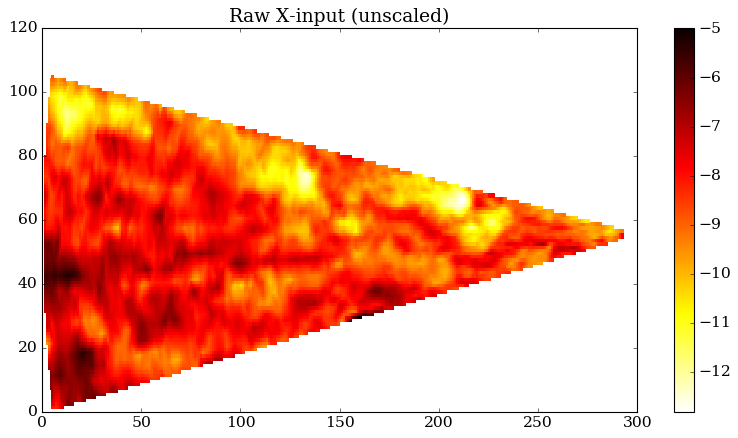

In [14]:
# Plot one to check
plt.pcolormesh(X_input_data[:,:,0])
plt.colorbar()
plt.title('Raw X-input (unscaled)');

In [15]:
# Absolute value everything to make speeds positive
X_input_data = np.abs(X_input_data)

In [16]:
# Reshape to correct input (Time, Y, X, C-features)
# Last axis is added even though only 1 channel exists
X_input_data = np.moveaxis(X_input_data, -1, 0)
X_input_data = X_input_data[:,:,:,np.newaxis]

#X_input_data = X_input_data.reshape(X_input_data.shape[0], X_input_data.shape[1], X_input_data.shape[2], 1)
X_input_shape = X_input_data.shape
print(X_input_shape)

(3270, 106, 294, 1)


### Lidar Reconstructed Speeds (X)

In [0]:
#X_input_data = df_13s.iloc[:,15:212]
#print(X_input_data.shape)

# y-Data

In [17]:
# Read in already prepared mast-dataset, including already decomposed u & v
#df_13s = pd.read_hdf('df_joined_13s_Nov14_15.hdf','df')
df_13s = pd.read_hdf('Nov14-15_joined.hdf','df')
print(df_13s.shape)
# Remove last value to match lidar input shape (last scan was partial)
df_13s = df_13s.iloc[0:-1]
print(df_13s.shape)

(3271, 415)
(3270, 415)


In [ ]:
# See what kind of data we have from the mast & turbine
print(df_13s.columns.tolist())

### Mast data u&v (y)

In [0]:
# Make some random Y data for initial testing 
#y_input_data = np.random.weibull(7, size=(X_input_shape[0],1))
#print(y_input_data.shape)

In [0]:
# Load mast data and already calculated u,v
# Has been resampled from 50Hz to 1s already
#starttime = '201711141400'
#endtime = '201711150200'
#filename = starttime + "_" + endtime

#df_mast_1s = pd.read_hdf(filename + '_1s.hd5','df')

In [0]:
# Timestamps already accounted for when prepping data
# Shift timestamp to match windscanner
# 60 minutes for UTC-CET conversion, and 10 minutes to stamping notation
#df_mast_1s = df_mast_1s.shift(freq=pd.Timedelta(minutes=-70))

In [0]:
# Resample to 13 second periods
#print(df_mast_1s.shape[0]/13)
#df_mast_13s = df_mast_1s.resample('13S').mean()
#df_mast_13s = df_mast_1s.rolling('13S').mean()
#print(df_mast_13s.shape[0])

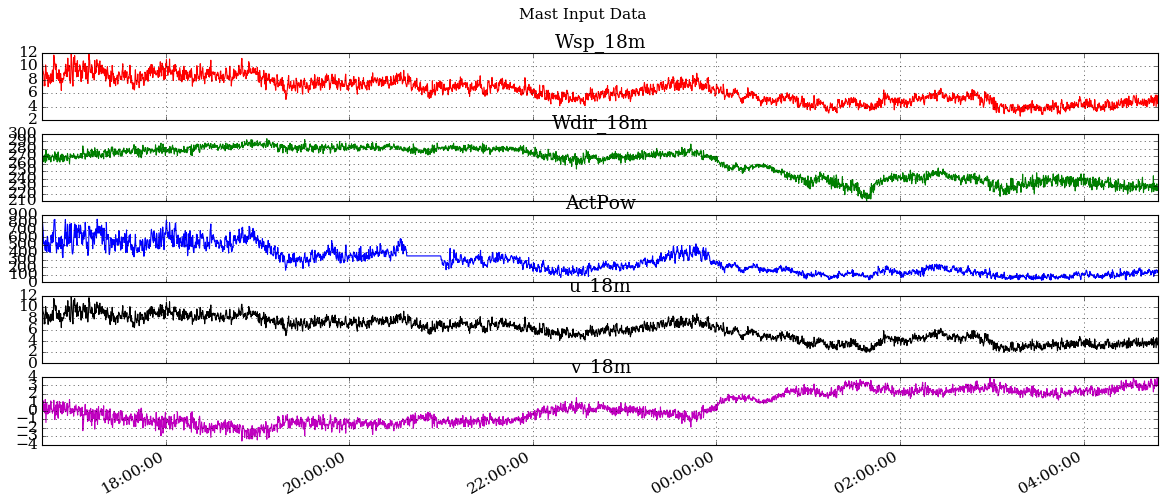

In [96]:
# Inspect time series
f, axarr = plt.subplots(5,1, figsize=(18,7))
axarr[0].plot(df_13s['SWsp_18m'], c='r')
axarr[1].plot(df_13s['Sdir_18m'], c='g')
axarr[2].plot(df_13s['ActPow'], c='b')
axarr[3].plot(df_13s['u_18m'], c='k')
axarr[4].plot(df_13s['v_18m'], c='m')


plt.suptitle('Mast Input Data', fontsize=14)
axarr[0].set_title('Wsp_18m')
axarr[1].set_title('Wdir_18m')
axarr[2].set_title('ActPow')
axarr[3].set_title('u_18m')
axarr[4].set_title('v_18m')
f.autofmt_xdate()

In [15]:
# Format our Y input from the mast data
# 2D, u & v horizontal components
y_input_data = np.vstack([df_13s['u_44m'], df_13s['v_44m']])
y_input_data = np.moveaxis(y_input_data, -1, 0)

print(y_input_data.shape)

(3270, 2)


In [17]:
# Format our Y input from the mast data
# 1D, Sonic wind speed 18m
#y_input_data = df_13s['SWsp_18m']
#print(y_input_data.shape)

### Brise DBS (y)

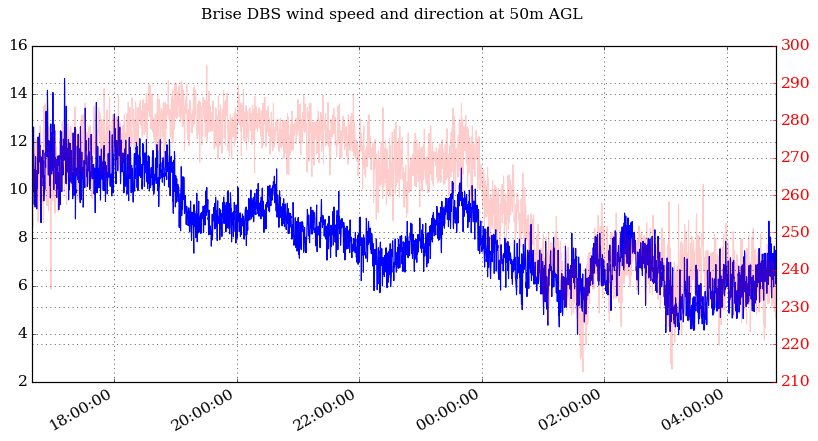

In [18]:
f = plt.figure()
ax = df_13s['wsp'].plot()
ax2 = ax.twinx()
df_13s['wdir'].plot(ax=ax2, c='r', alpha=0.2)
ax2.tick_params('y', colors='r')
plt.suptitle('Brise DBS wind speed and direction at 50m AGL');

In [19]:
# Format our Y input from the Brise DBS obs
# 2D, u & v horizontal components
y_input_data = np.vstack([df_13s['u'], df_13s['v']])
y_input_data = np.moveaxis(y_input_data, -1, 0)

print(y_input_data.shape)

(3270, 2)


## Persistence

In [140]:
# Make shifted dataframe for persistence
# Same value is used at t and t + delta t from 0-24 times ahead
df_pers = pd.DataFrame(index=df_13s.index)
print(df_pers.shape)

df_pers[0] = df_13s['wsp']

for i in range(1,leads+1):
    df_pers[i] = df_pers[0].shift(-i)
    
del df_pers[0]
df_pers.columns = np.arange(0,df_pers.shape[1])

#df_pers.dropna(how='any', inplace=True)
df_pers = df_pers.iloc[:-leads]
df_pers = df_pers.iloc[lags:]
print(df_pers.shape)

(3220, 0)
(3170, 25)


In [560]:
#plt.scatter(df_13s.iloc[lags:-leads]['wsp'], df_pers[0])

In [ ]:
df_pers[0].plot()
df_pers[24].plot()

In [ ]:
# Check lead n
pers_metrics(df_pers[0], df_pers[1])

In [ ]:
# Check all leads
df_pers_rmse = []
for i in range(1,leads):
    print('--------------------------------------------------------------------')
    print('Lead time = ' + str(i) + ' (' + str(np.round((i*13)/60,2)) + ') mins')
    e = pers_metrics(df_pers[0], df_pers[i])
    df_pers_rmse.append(e)
df_pers_rmse = pd.DataFrame(df_pers_rmse)

In [143]:
df_pers_rmse['t'] = ((df_pers_rmse.index+1) * 13) / 60
df_pers_rmse.set_index(df_pers_rmse['t'], inplace=True)
del df_pers_rmse['t']

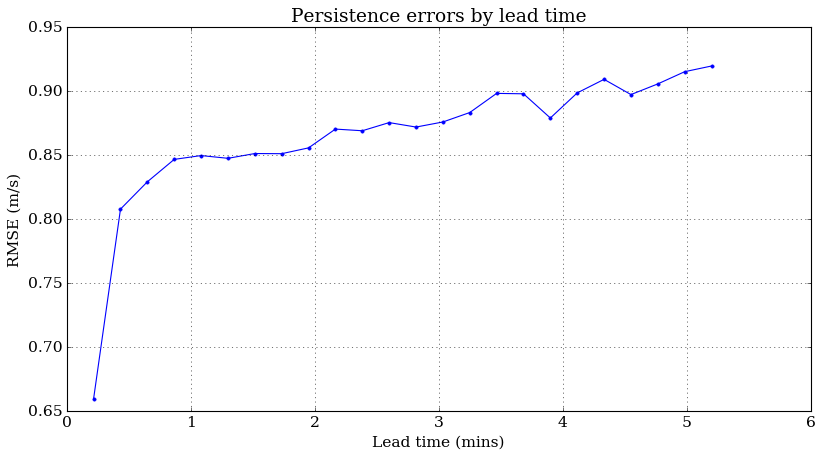

In [144]:
df_pers_rmse.plot(legend=None, marker='.')
plt.title('Persistence errors by lead time')
plt.xlabel('Lead time (mins)')
plt.ylabel('RMSE (m/s)');

## More pre-processing and checks

# Train/test split

In [100]:
# Sub-select just a small test dataset
X_small = X_input_data[0:250,:,:,:]
y_small = y_input_data[0:250,:]

In [103]:
%%time
# Split up train/test data by breakpoint
X_train, X_test, y_train, y_test = train_test_split(X_input_data, y_input_data, test_size=0.33, random_state=42, shuffle=False)
#X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.33, random_state=42, shuffle=False)

Wall time: 1min 28s


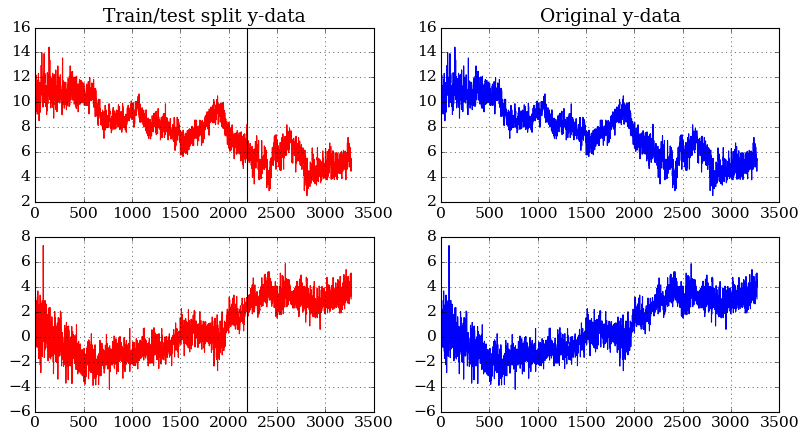

In [104]:
# Check that our TTS went correctly, and indicate breakpoint

f = plt.figure()
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax.plot(np.concatenate([y_train[:,0], y_test[:,0]]), c='r')
ax3.plot(np.concatenate([y_train[:,1], y_test[:,1]]), c='r')
ax.axvline(len(y_train), c='k')
ax3.axvline(len(y_train), c='k')
ax.set_title('Train/test split y-data')
ax2.plot(y_input_data[:,0])
ax4.plot(y_input_data[:,1])
ax2.set_title('Original y-data');

In [105]:
# Get scalar wind speed for y-test
y_test_ws = np.sqrt((y_test[:,0])**2 + (y_test[:,1])**2)

# Scale and TTS

### X-data

In [20]:
X_input_data.shape

(3270, 106, 294, 1)

In [17]:
# X-scaling (old method, not robust to outliers)
X_scaled = np.empty_like(X_input_data)

X_min = np.nanmin(X_input_data, axis=(1, 2), keepdims=True)
X_max = np.nanmax(X_input_data, axis=(1, 2), keepdims=True)

X_scaled = (X_input_data - X_min)/(X_max-X_min)

In [21]:
# X-scaling
X_scaled = np.empty_like(X_input_data)

X_mean = np.nanmean(X_input_data, axis=(1, 2), keepdims=True)
X_min = np.nanmin(X_input_data, axis=(1, 2), keepdims=True)
X_std = np.nanstd(X_input_data, axis=(1, 2), keepdims=True)
X_max = X_std * 4 + X_mean

X_scaled = (X_input_data - X_min)/(X_max-X_min)

In [22]:
del X_mean
del X_min
del X_std
del X_max

In [23]:
# Mask values above 1
X_scaled[X_scaled > 1] = np.nan

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [24]:
X_scaled = np.nan_to_num(X_scaled)

In [25]:
del X_input_data

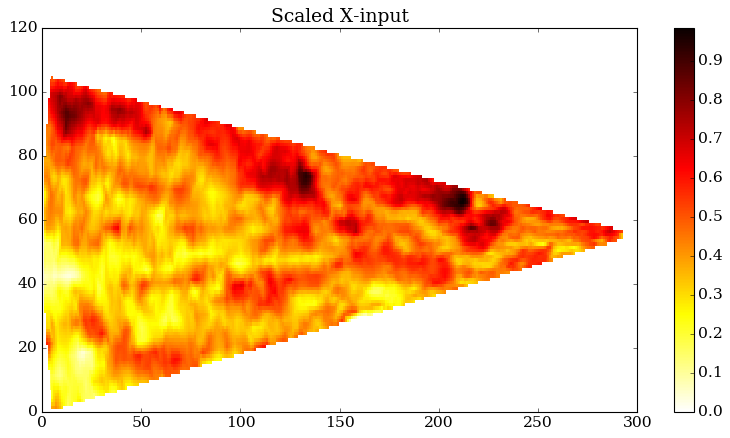

In [26]:
# Check one scan (radial speeds)
plt.pcolormesh(X_scaled[0,:,:,0])
plt.title('Scaled X-input')
plt.colorbar();

In [20]:
%%time
# Save scaled images out

for i in range(0,len(X_scaled),1):
    plt.pcolormesh(X_scaled[i,:,:,0])
    plt.title('Scaled X-input: ' + 'index ' + str(i) + ' at ' + str(df_13s.index[i]))
    plt.savefig('.\\plots\\x_scaled_img\\' + str(i) + '.png', dpi=100)
    plt.close('all')

Wall time: 27min 45s


### y-data

In [27]:
y_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y_scaled = y_scaler.fit_transform(y_input_data)
y_scaled = np.nan_to_num(y_scaled)

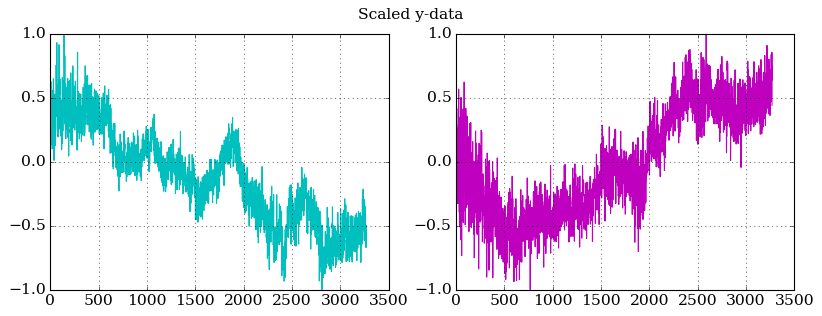

In [28]:
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(y_scaled[:,0], c='c')
ax2.plot(y_scaled[:,1], c='m')
plt.suptitle('Scaled y-data');

### Add lags and reshape for LSTM

In [29]:
leads = 25
lags = 25

#### y-Data

In [ ]:
# y-data (backward lag)
lags=25
y_scaled_lag = y_scaled.copy()
y_scaled_lag = y_scaled_lag[:,np.newaxis,:]
print(y_scaled_lag.shape)
y_scaled_lag = pad_along_axis(y_scaled_lag, lags, axis=1)

for i in range(lags,y_scaled_lag.shape[0]):
    #v = np.arange(i-49, i+1, 1)
    y_scaled_lag[i,:,0] = np.flip(y_scaled_lag[i-lags+1:i+1,0,0], axis=0)
    y_scaled_lag[i,:,1] = np.flip(y_scaled_lag[i-lags+1:i+1,0,1], axis=0)

y_scaled_lag = y_scaled_lag[lags:]
print('reduced by lags at beginning = {0}'.format(lags))
print(y_scaled_lag.shape)

In [30]:
# y-data (forward prediction)
y_scaled_leads = y_scaled.copy()
y_scaled_leads = y_scaled_leads[:,np.newaxis,:]
print(y_scaled_leads.shape)
y_scaled_leads = pad_along_axis(y_scaled_leads, leads, axis=1)

for i in range(0,y_scaled_leads.shape[0]-leads,1):
    #v = np.arange(i-49, i+1, 1)
    y_scaled_leads[i,:,0] = y_scaled_leads[i:i+leads,0,0]
    y_scaled_leads[i,:,1] = y_scaled_leads[i:i+leads,0,1]
print('done!')

(3270, 1, 2)
done!


In [31]:
y_scaled_leads = y_scaled_leads[0:-leads]
print('reduced by leads at end = {0}'.format(leads))
print(y_scaled_leads.shape)
y_scaled_leads = y_scaled_leads[lags:]
print('reduced by lags at beginning = {0}'.format(leads))
print(y_scaled_leads.shape)

reduced by leads at end = 25
(3245, 25, 2)
reduced by lags at beginning = 25
(3220, 25, 2)


In [32]:
# Make labeled data the same length
df_13s = df_13s.iloc[lags:-leads]
print(df_13s.shape)

(3220, 415)


In [ ]:
# Do also for unscaled data!

In [33]:
del y_input_data
del y_scaled

#### X-data

In [34]:
X_scaled.shape

(3270, 106, 294, 1)

In [ ]:
# old method of padding (X)
#lags=10
#X_scaled_lag = X_scaled.copy()
#X_scaled_lag = X_scaled_lag[:,np.newaxis,:,:,:]
#print(X_scaled_lag.shape)
#X_scaled_lag = pad_along_axis(X_scaled_lag, lags, axis=1)
#print(X_scaled_lag.shape)

In [35]:
# X-data (init, reshape and copy)

X_scaled_lag = np.zeros((X_scaled.shape[0],lags,X_scaled.shape[1],X_scaled.shape[2],X_scaled.shape[3]), X_scaled.dtype)
print('..initializing array..')
X_scaled_lag[:,0] = X_scaled
print(X_scaled_lag.shape)

..initializing array..
(3270, 25, 106, 294, 1)


In [36]:
%%time
# X-data (copy in lags)
print('..copying lags..')
for i in range(lags,X_scaled_lag.shape[0],1):

    #X_scaled_lag[i,:,:,:,0] = np.flip(X_scaled_lag[i-lags+1:i+1,:,:,:,0], axis=0)
    X_scaled_lag[i,:] = X_scaled[i-lags+1:i+1]
    
    if i % 500 == 0:
        print(i)
print('done!')

..copying lags..
500
1000
1500
2000
2500
3000
done!
Wall time: 6min 57s


In [37]:
X_scaled_lag = X_scaled_lag[lags:]
print('reduced by lags at beginning = {0}'.format(lags))
print(X_scaled_lag.shape)

X_scaled_lag = X_scaled_lag[0:-leads]
print('reduced by leads at end = {0}'.format(leads))
print(X_scaled_lag.shape)

reduced by lags at beginning = 25
(3245, 25, 106, 294, 1)
reduced by leads at end = 25
(3220, 25, 106, 294, 1)


In [38]:
del X_scaled

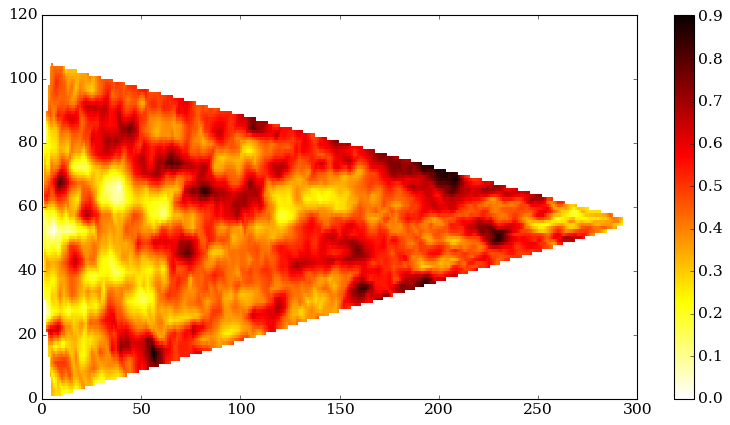

In [39]:
plt.pcolormesh(X_scaled_lag[0,12,:,:,0])
plt.colorbar()

## TTS

In [20]:
# TTS
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled_lag, test_size=0.33, random_state=42, shuffle=False)

In [21]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train_scaled.shape)
print(y_test_scaled.shape)

(2157, 1, 201, 394, 1)
(1063, 1, 201, 394, 1)
(2157, 50, 2)
(1063, 50, 2)


## X-Scaling

In [0]:
# No scaling
#X_train_scaled = X_train.copy()
#X_test_scaled = X_test.copy()

In [ ]:
# When X-data is a series of 2D images with 0 and 1 layers (u and v from optical flow)
X_train_scaled = np.empty_like(X_train)
X_test_scaled = np.empty_like(X_test)

# Standard scaling
#X_train_scaled[:,:,:,0] = (X_train[:,:,:,0] - np.nanmean(X_train[:,:,:,0], axis=None))/np.nanstd(X_train[:,:,:,0], axis=None)
#X_train_scaled[:,:,:,1] = (X_train[:,:,:,1] - np.nanmean(X_train[:,:,:,1], axis=None))/np.nanstd(X_train[:,:,:,1], axis=None)
#X_test_scaled[:,:,:,0] = (X_test[:,:,:,0] - np.nanmean(X_test[:,:,:,0], axis=None))/np.nanstd(X_test[:,:,:,0], axis=None)
#X_test_scaled[:,:,:,1] = (X_test[:,:,:,1] - np.nanmean(X_test[:,:,:,1], axis=None))/np.nanstd(X_test[:,:,:,1], axis=None)
# Mean subtraction / Range(max-min)
X_train_scaled[:,:,:,0] = (X_train[:,:,:,0] - np.nanmean(X_train[:,:,:,0], axis=None))/(np.nanmax(X_train[:,:,:,0], axis=None) - np.nanmin(X_train[:,:,:,0], axis=None))
X_train_scaled[:,:,:,1] = (X_train[:,:,:,1] - np.nanmean(X_train[:,:,:,1], axis=None))/(np.nanmax(X_train[:,:,:,1], axis=None) - np.nanmin(X_train[:,:,:,1], axis=None))
X_test_scaled[:,:,:,0] = (X_test[:,:,:,0] - np.nanmean(X_test[:,:,:,0], axis=None))/(np.nanmax(X_test[:,:,:,0], axis=None) - np.nanmin(X_test[:,:,:,0], axis=None))
X_test_scaled[:,:,:,1] = (X_test[:,:,:,1] - np.nanmean(X_test[:,:,:,1], axis=None))/(np.nanmax(X_test[:,:,:,1], axis=None) - np.nanmin(X_test[:,:,:,1], axis=None))

In [107]:
# Scale properly with X_train and X_test scaled separately (because we won't know scale beforehand)
# When X-data is a series of flat 2D images (i.e. lidar scans themselves)
# Don't need to use sklearn since we aren't inverse transforming later
X_train_scaled = np.empty_like(X_train)
X_test_scaled = np.empty_like(X_test)

# Mean subtraction / Range(max-min)
X_train_scaled = (X_train - np.nanmean(X_train, axis=None))/(np.nanmax(X_train, axis=None) - np.nanmin(X_train, axis=None))
X_test_scaled = (X_test - np.nanmean(X_test, axis=None))/(np.nanmax(X_test, axis=None) - np.nanmin(X_test, axis=None))

In [17]:
# Delete old data to save memory
del(X_input_data)
del(X_train)
del(X_test)

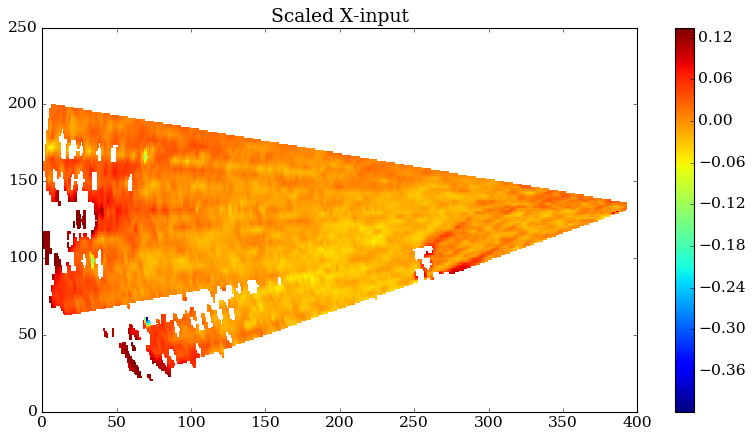

In [108]:
# Check first scan (radial speeds)
plt.pcolormesh(X_test_scaled.reshape(X_test_scaled.shape[0],201,394)[102])
plt.title('Scaled X-input')
plt.colorbar();

In [24]:
# Fill any NaNs to zero, if they exist

X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)

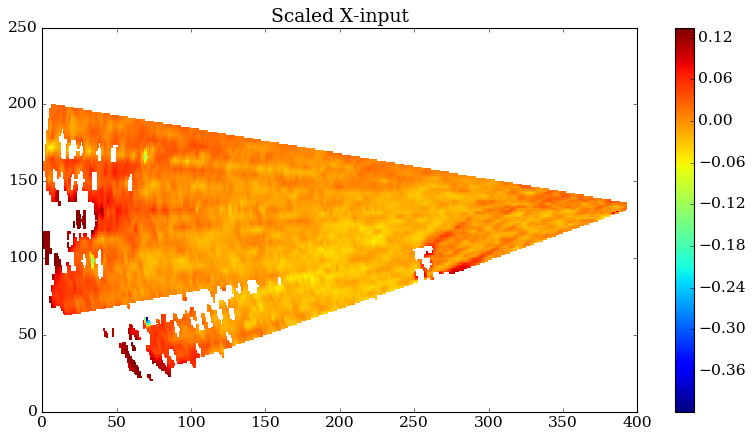

In [109]:
# Check one random scan (optical flows)
plt.pcolormesh(X_test_scaled[102,:,:,0])
plt.title('Scaled X-input')
plt.colorbar()

In [ ]:
# Check mean and var (2D)

print(np.nanmean(X_train_scaled[:,:,:,0]))
print(np.nanvar(X_train_scaled[:,:,:,0]))
print(np.nanmean(X_test_scaled[:,:,:,0]))
print(np.nanvar(X_test_scaled[:,:,:,0]))
print(np.nanmean(X_train_scaled[:,:,:,1]))
print(np.nanvar(X_train_scaled[:,:,:,1]))
print(np.nanmean(X_test_scaled[:,:,:,1]))
print(np.nanvar(X_test_scaled[:,:,:,1]))

In [111]:
# Check mean and var (1D)

print(np.nanmean(X_train_scaled))
print(np.nanvar(X_train_scaled))
print(np.nanmean(X_test_scaled))
print(np.nanvar(X_test_scaled))

-3.0532056751754564e-16
0.0034457244214285603
4.570689665469156e-16
0.0011338277873070666


## Y-Scaling

In [112]:
# Use one scaler for each y_train/y_test
# Use scikit functions (in order to inverse transform later)

y_train_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y_test_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

#y_train_scaler = preprocessing.RobustScaler()
#y_test_scaler = preprocessing.RobustScaler()

#y_train_scaler = preprocessing.StandardScaler()
#y_test_scaler = preprocessing.StandardScaler()

#y_train_scaled = np.empty_like(y_train)
#y_test_scaled = np.empty_like(y_test)

y_train_scaled = y_train_scaler.fit_transform(y_train)
y_test_scaled = y_test_scaler.fit_transform(y_test)

In [67]:
# Use separate scalers for both channels (apparently does the same thing)
# Use scikit functions (in order to inverse transform later)
#y_train_u_scaler = preprocessing.RobustScaler()
#y_train_v_scaler = preprocessing.RobustScaler()

#y_test_u_scaler = preprocessing.RobustScaler()
#y_test_v_scaler = preprocessing.RobustScaler()

y_train_u_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y_train_v_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

y_test_u_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y_test_v_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

y_train_scaled = np.empty_like(y_train)
y_test_scaled = np.empty_like(y_test)

y_train_scaled[:,0] = y_train_u_scaler.fit_transform(y_train[:,0].reshape(-1, 1)).flatten()
y_train_scaled[:,1] = y_train_v_scaler.fit_transform(y_train[:,1].reshape(-1, 1)).flatten()

y_test_scaled[:,0] = y_test_u_scaler.fit_transform(y_test[:,0].reshape(-1, 1)).flatten()
y_test_scaled[:,1] = y_test_v_scaler.fit_transform(y_test[:,1].reshape(-1, 1)).flatten()


In [47]:
# When y-data is 2-D data (time series of u & v)
y_train_scaled = np.empty_like(y_train)
y_test_scaled = np.empty_like(y_test)
# Standard scaling
#y[:,0] = (y_input_data[:,0] - np.nanmean(y_input_data[:,0], axis=None))/np.nanstd(y_input_data[:,0], axis=None)
#y[:,1] = (y_input_data[:,1] - np.nanmean(y_input_data[:,1], axis=None))/np.nanstd(y_input_data[:,1], axis=None)

# Mean subtraction / Range(max-min)
y_train_scaled[:,0] = (y_train[:,0] - np.nanmean(y_train[:,0], axis=None))/(np.nanmax(y_train[:,0], axis=None) - np.nanmin(y_train[:,0], axis=None))
y_train_scaled[:,1] = (y_train[:,1] - np.nanmean(y_train[:,1], axis=None))/(np.nanmax(y_train[:,1], axis=None) - np.nanmin(y_train[:,1], axis=None))

y_test_scaled[:,0] = (y_test[:,0] - np.nanmean(y_test[:,0], axis=None))/(np.nanmax(y_test[:,0], axis=None) - np.nanmin(y_test[:,0], axis=None))
y_test_scaled[:,1] = (y_test[:,1] - np.nanmean(y_test[:,1], axis=None))/(np.nanmax(y_test[:,1], axis=None) - np.nanmin(y_test[:,1], axis=None))

In [0]:
# When y-data is 1-D data (wind speed, active power, etc)
# Standard scaling
y = np.empty_like(y_input_data)
#y = (y_input_data - np.nanmean(y_input_data, axis=None))/np.nanstd(y_input_data, axis=None)
# Mean subtraction / Range(max-min)
y = (y_input_data - np.nanmean(y_input_data, axis=None))/(np.nanmax(y_input_data, axis=None) - np.nanmin(y_input_data, axis=None))

In [113]:
# Check the mean and variance (2D)

print(np.nanmean(y_train_scaled[:,0]))
print(np.nanvar(y_train_scaled[:,0]))
print(np.nanmean(y_train_scaled[:,1]))
print(np.nanvar(y_train_scaled[:,1]))
print(np.nanmean(y_test_scaled[:,0]))
print(np.nanvar(y_test_scaled[:,0]))
print(np.nanmean(y_test_scaled[:,1]))
print(np.nanvar(y_test_scaled[:,1]))

-0.1332482616177635
0.0975365096051532
-0.3521742022325936
0.05411842665036048
-0.013927925674158249
0.11435092174365864
-0.02691003041012031
0.07643457368910452


In [27]:
#Fill NaNs (if they exist) with 0

y_train_scaled = np.nan_to_num(y_train_scaled)
y_test_scaled = np.nan_to_num(y_test_scaled)

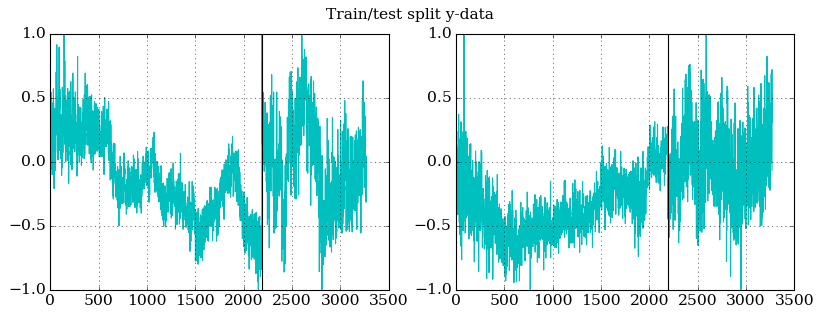

In [114]:
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(np.concatenate([y_train_scaled[:,0], y_test_scaled[:,0]]), c='c')
ax2.plot(np.concatenate([y_train_scaled[:,1], y_test_scaled[:,1]]), c='c')
ax.axvline(len(y_train_scaled), c='k')
ax2.axvline(len(y_train_scaled), c='k')
plt.suptitle('Train/test split y-data');

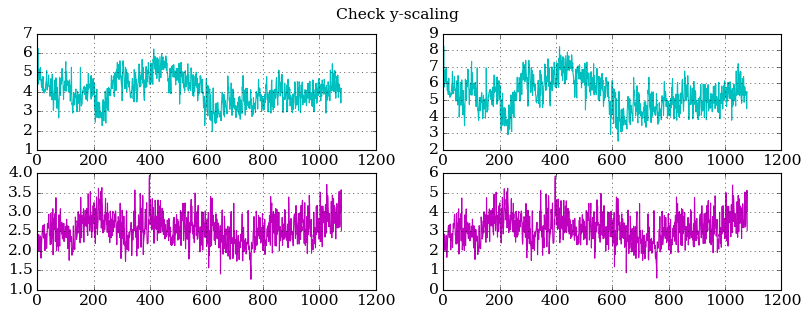

In [115]:
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax.plot(y_test_u_scaler.inverse_transform(y_test_scaled)[:,0], c='c')
ax2.plot(y_test[:,0], c='c')
ax3.plot(y_test_v_scaler.inverse_transform(y_test_scaled)[:,1], c='m')
ax4.plot(y_test[:,1], c='m')
plt.suptitle('Check y-scaling');

## Conv2D

In [119]:
print(X_train_scaled.shape)
print(y_train_scaled.shape)

(2190, 201, 394, 1)
(2190, 2)


In [0]:
# Used for switching from ConvLSTM2D shape (remove timesteps)
X_train_scaled = np.squeeze(X_train_scaled)
X_test_scaled = np.squeeze(X_test_scaled)
y_train_scaled = np.squeeze(y_train_scaled)
y_test_scaled = np.squeeze(y_test_scaled)

In [120]:
# Modified from DJG's Swirlflow tutorial: 
# https://github.com/djgagne/swirlnet/blob/master/notebooks/deep_swirl_tutorial.ipynb

# Input data in shape (y, x, variables)
l2_a= 0.001
conv_net_in = Input(shape=X_train_scaled.shape[1:])
# First 2D convolution Layer
conv_net = Conv2D(16, (5, 5), padding="same", kernel_regularizer=l2(l2_a))(conv_net_in)
conv_net = Activation("relu")(conv_net)
#conv_net = BatchNormalization()(conv_net)
conv_net = Dropout(0.1)(conv_net)
# Average pooling takes the mean in a 2x2 neighborhood to reduce the image size
conv_net = AveragePooling2D()(conv_net)
# Second set of convolution and pooling layers
conv_net = Conv2D(32, (5, 5), padding="same", kernel_regularizer=l2(l2_a))(conv_net)
conv_net = Activation("relu")(conv_net)
#conv_net = BatchNormalization()(conv_net)
conv_net = Dropout(0.1)(conv_net)
conv_net = AveragePooling2D()(conv_net)
# Third set of convolution and pooling layers
conv_net = Conv2D(64, (5, 5), padding="same", kernel_regularizer=l2(l2_a))(conv_net)
conv_net = Activation("relu")(conv_net)
#conv_net = BatchNormalization()(conv_net)
conv_net = Dropout(0.1)(conv_net)
conv_net = AveragePooling2D()(conv_net)
# Flatten the last convolutional layer into a long feature vector
conv_net = Flatten()(conv_net)
# Add second input layer here?
#conv_net_in = Input(shape=y.shape[1:])
# Keras concat layers?
# Dense output layer
conv_net = Dense(2)(conv_net)
conv_model = Model(conv_net_in, conv_net)
# Use the Adam optimizer with default parameters
opt = Adam()
conv_model.compile(opt, loss='mean_squared_error')

In [121]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 201, 394, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 201, 394, 16)      416       
_________________________________________________________________
activation_4 (Activation)    (None, 201, 394, 16)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 201, 394, 16)      0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 100, 197, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 197, 32)      12832     
_________________________________________________________________
activation_5 (Activation)    (None, 100, 197, 32)      0         
__________

In [74]:
%%time
#early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1, min_delta=0.00001)

batch_size = 64
epochs = 500
model_hist = conv_model.fit(X_train_scaled, y_train_scaled,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_scaled, y_test_scaled)) #, callbacks=[early_stop])

Train on 2190 samples, validate on 1080 samples
Epoch 1/500
2190/2190 [==============================] - 428s 195ms/step - loss: 0.0864 - val_loss: 0.1893
Epoch 2/500
2190/2190 [==============================] - 427s 195ms/step - loss: 0.0526 - val_loss: 0.2452
Epoch 3/500
2190/2190 [==============================] - 431s 197ms/step - loss: 0.0432 - val_loss: 0.2164
Epoch 4/500
2190/2190 [==============================] - 426s 195ms/step - loss: 0.0373 - val_loss: 0.1983
Epoch 5/500
2190/2190 [==============================] - 420s 192ms/step - loss: 0.0338 - val_loss: 0.2228
Epoch 6/500
2190/2190 [==============================] - 420s 192ms/step - loss: 0.0336 - val_loss: 0.2049
Epoch 7/500
2190/2190 [==============================] - 422s 192ms/step - loss: 0.0307 - val_loss: 0.2205
Epoch 8/500
2190/2190 [==============================] - 422s 193ms/step - loss: 0.0284 - val_loss: 0.1811
Epoch 9/500
2190/2190 [==============================] - 420s 192ms/step - loss: 0.0276 - val_lo

2190/2190 [==============================] - 420s 192ms/step - loss: 0.0053 - val_loss: 0.2227
Epoch 152/500
2190/2190 [==============================] - 421s 192ms/step - loss: 0.0053 - val_loss: 0.2266
Epoch 153/500
2190/2190 [==============================] - 419s 191ms/step - loss: 0.0055 - val_loss: 0.2288
Epoch 154/500
2190/2190 [==============================] - 418s 191ms/step - loss: 0.0053 - val_loss: 0.2108
Epoch 155/500
2190/2190 [==============================] - 422s 193ms/step - loss: 0.0056 - val_loss: 0.2164
Epoch 156/500
2190/2190 [==============================] - 418s 191ms/step - loss: 0.0052 - val_loss: 0.2267
Epoch 157/500
2190/2190 [==============================] - 416s 190ms/step - loss: 0.0053 - val_loss: 0.2188
Epoch 158/500
2190/2190 [==============================] - 419s 191ms/step - loss: 0.0051 - val_loss: 0.2155
Epoch 159/500
2190/2190 [==============================] - 421s 192ms/step - loss: 0.0057 - val_loss: 0.2061
Epoch 160/500
2190/2190 [========

2190/2190 [==============================] - 421s 192ms/step - loss: 0.0043 - val_loss: 0.2362
Epoch 302/500
2190/2190 [==============================] - 419s 191ms/step - loss: 0.0043 - val_loss: 0.2297
Epoch 303/500
2190/2190 [==============================] - 419s 191ms/step - loss: 0.0041 - val_loss: 0.2141
Epoch 304/500
2190/2190 [==============================] - 419s 191ms/step - loss: 0.0040 - val_loss: 0.2295
Epoch 305/500
2190/2190 [==============================] - 415s 189ms/step - loss: 0.0042 - val_loss: 0.2148
Epoch 306/500
2190/2190 [==============================] - 416s 190ms/step - loss: 0.0042 - val_loss: 0.2205
Epoch 307/500
2190/2190 [==============================] - 418s 191ms/step - loss: 0.0042 - val_loss: 0.2271
Epoch 308/500
2190/2190 [==============================] - 418s 191ms/step - loss: 0.0042 - val_loss: 0.2205
Epoch 309/500
2190/2190 [==============================] - 418s 191ms/step - loss: 0.0043 - val_loss: 0.2165
Epoch 310/500
2190/2190 [========

2190/2190 [==============================] - 416s 190ms/step - loss: 0.0038 - val_loss: 0.2168
Epoch 452/500
2190/2190 [==============================] - 417s 191ms/step - loss: 0.0038 - val_loss: 0.2324
Epoch 453/500
2190/2190 [==============================] - 418s 191ms/step - loss: 0.0038 - val_loss: 0.2340
Epoch 454/500
2190/2190 [==============================] - 421s 192ms/step - loss: 0.0038 - val_loss: 0.2348
Epoch 455/500
2190/2190 [==============================] - 416s 190ms/step - loss: 0.0038 - val_loss: 0.2284
Epoch 456/500
2190/2190 [==============================] - 420s 192ms/step - loss: 0.0036 - val_loss: 0.2199
Epoch 457/500
2190/2190 [==============================] - 418s 191ms/step - loss: 0.0037 - val_loss: 0.2286
Epoch 458/500
2190/2190 [==============================] - 422s 192ms/step - loss: 0.0039 - val_loss: 0.2151
Epoch 459/500
2190/2190 [==============================] - 421s 192ms/step - loss: 0.0039 - val_loss: 0.2193
Epoch 460/500
2190/2190 [========

In [50]:
preds_scaled = conv_model.predict(X_test_scaled, batch_size=batch_size, verbose=1)
print(preds_scaled.shape)

1080/1080 [==============================] - 2s 2ms/step
(1080, 2)


In [51]:
preds = y_test_scaler.inverse_transform(preds_scaled)

In [0]:
np.save('cnn_updated_flows_preds.npy', preds)

In [0]:
save_model(conv_model, 'cnn_updated_flows_model.hdf')

In [52]:
# Get scalar wind speed for predictions
preds_ws = np.sqrt((preds[:,0])**2 + (preds[:,1])**2)

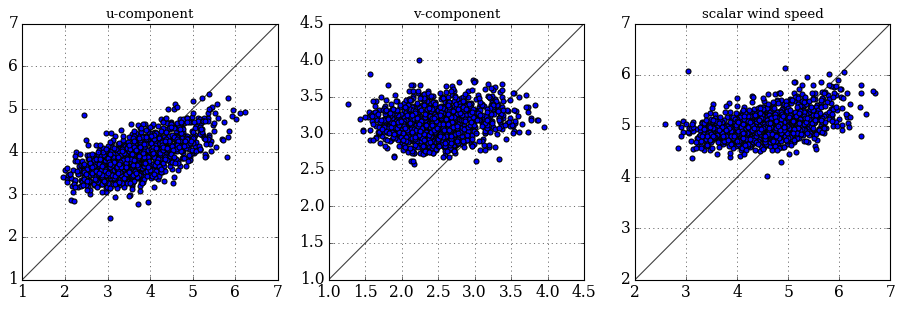

In [53]:
performance_scatter(y_test, y_test_ws, preds, preds_ws)

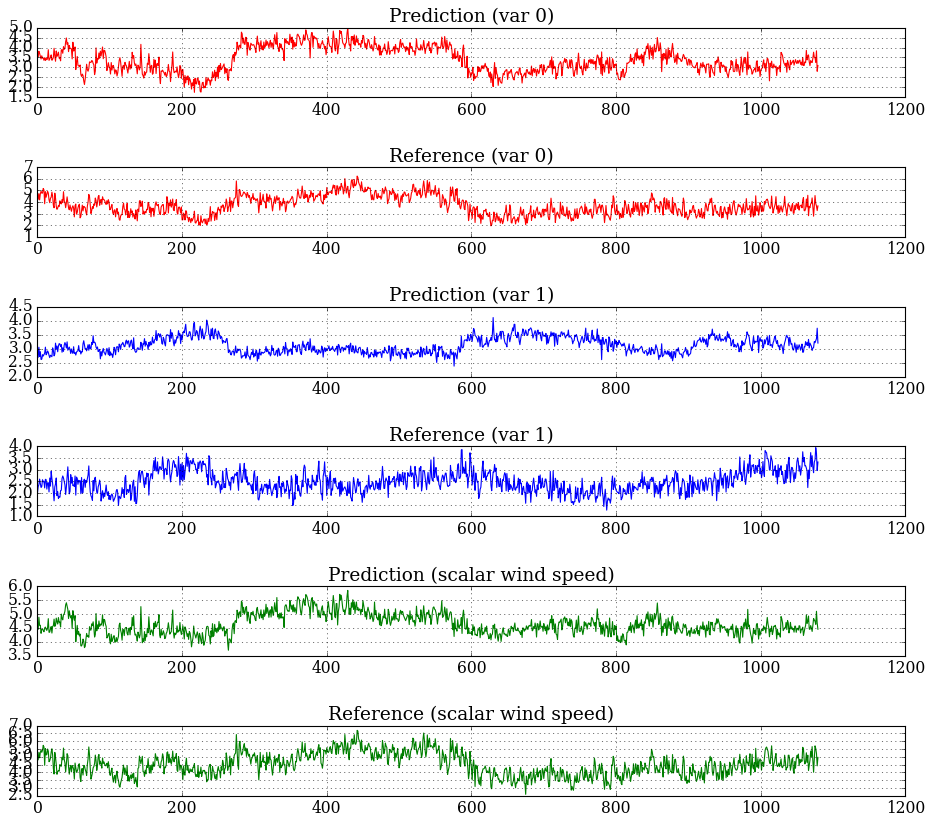

In [44]:
performance_ts(y_test, y_test_ws, preds, preds_ws)

In [45]:
print('VARIABLE 0: U COMPONENT')
print(ols_fit_summary(y_test, preds, var_num=0))
print('VARIABLE 1: V COMPONENT')
print(ols_fit_summary(y_test, preds, var_num=1))
print('SCALAR WIND SPEED')
print(ols_fit_summary(y_test_ws, preds_ws, single_var=True))

VARIABLE 0: U COMPONENT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     1003.
Date:                Fri, 17 Aug 2018   Prob (F-statistic):          3.82e-156
Time:                        14:34:26   Log-Likelihood:                -956.15
No. Observations:                1080   AIC:                             1916.
Df Residuals:                    1078   BIC:                             1926.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6856      0

In [54]:
# Returned as: mae, mse, rmse
print('VARIABLE 0: U COMPONENT')
print(forcast_metrics(x=y_test, y=preds, var_num=0))
print('VARIABLE 1: V COMPONENT')
print(forcast_metrics(x=y_test, y=preds, var_num=1))
print('SCALAR WIND SPEED')
print(forcast_metrics(x=y_test_ws, y=preds_ws, single_var=True))

VARIABLE 0: U COMPONENT
(0.5232729630051202, 0.41145864478247757, 0.6414504227003655)
VARIABLE 1: V COMPONENT
(0.6989164070393661, 0.668390228732197, 0.8175513615254989)
SCALAR WIND SPEED
(0.6826428207268722, 0.6907705033062553, 0.8311260453783501)


# ConvLSTM2D (1 layer)

In [40]:
#X_train, X_test, y_train, y_test
print(X_scaled_lag.shape)

(3220, 25, 106, 294, 1)


In [0]:
# Find divisors with remainder 0
for i in range(1,50+1):
    if X.shape[0]%i == 0:
        print(i)

In [ ]:
# Reshape into timesteps (done earlier now)

# Add a new axis with length 1 (timestep)
X_train_scaled = X_train_scaled[:, np.newaxis, :, :, :]
print(X_train_scaled.shape)
X_test_scaled = X_test_scaled[:, np.newaxis, :, :, :]
print(X_test_scaled.shape)

y_train_scaled = y_train_scaled[:, np.newaxis, :]
print(y_train_scaled.shape)
y_test_scaled = y_test_scaled[:, np.newaxis, :]
print(y_test_scaled.shape)

In [ ]:
# Old shapes
print(X_train_scaled.shape)
print(y_train_scaled.shape)
print(X_test_scaled.shape)
print(y_test_scaled.shape)

In [53]:
# Conv LSTM 2D

# Input data in shape (samples, timesteps, y, x, variables)

#model_in = Input(shape=X_train_scaled.shape[1:])
model_in = Input(shape=X_scaled_lag.shape[1:], batch_shape=(1, X_scaled_lag.shape[1], X_scaled_lag.shape[2], X_scaled_lag.shape[3], X_scaled_lag.shape[4]))
opt = Adam()

# Only use 1 layer for now
# Average pooling on input?
model = ConvLSTM2D(32, (5, 5), return_sequences=True, activation='relu', padding='same', stateful=True)(model_in)
#print(keras.backend.shape(model))

model = Dropout(0.1)(model)
#model = MaxPooling3D(pool_size=(2,2,2))(model)
model = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(model)

# Shape output and compile
model = TimeDistributed(Flatten())(model)
# Dense layer = 2*timesteps
model = TimeDistributed(Dense(2))(model)
#model = Reshape((15,2), input_shape=(30,))(model)

model = Model(model_in, model)
model.compile(opt, loss='mean_squared_error')

In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (1, 25, 106, 294, 1)      0         
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (1, 25, 106, 294, 32)     38144     
_________________________________________________________________
dropout_4 (Dropout)          (1, 25, 106, 294, 32)     0         
_________________________________________________________________
time_distributed_10 (TimeDis (1, 25, 53, 147, 32)      0         
_________________________________________________________________
time_distributed_11 (TimeDis (1, 25, 249312)           0         
_________________________________________________________________
time_distributed_12 (TimeDis (1, 25, 2)                498626    
Total params: 536,770
Trainable params: 536,770
Non-trainable params: 0
_________________________________________________________________


## New method (walk-forward train+predict)

In [43]:
# Stateful, so manual state reset

In [55]:
print(X_scaled_lag.shape)
print(y_scaled_leads.shape)

(3220, 25, 106, 294, 1)
(3220, 25, 2)


In [56]:
def fit_model(model, X, y, nb_epoch = 1, n_batch = 1):
    for i in range(nb_epoch):
        #print('epoch #{}'.format(i))
        model_hist = model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()
    return model, model_hist

In [57]:
%%time
preds = []
preds_scaled = []
hists = []

print('..executing training & prediction..')
for i in range(0,len(X_scaled_lag)-1,1):
    
    if i % 50 == 0:
        print('At index: ' + str(i) + '. Time: ' + str(df_13s.index[i]))
    
    X_train = X_scaled_lag[i:i+1]
    y_train = y_scaled_leads[i:i+1]
    
    #print(X_train.shape)
    #print(y_train.shape)
    
    model, model_hist = fit_model(model, X_train, y_train, n_batch=1)
    hists.append(model_hist.history['loss'])
    
    X_test = X_scaled_lag[i+1:i+2]
    
    pred_scaled = model.predict(X_test, batch_size=1, verbose=1)
    pred_scaled = pred_scaled.reshape(pred_scaled.shape[1], pred_scaled.shape[2])
    
    pred = y_scaler.inverse_transform(pred_scaled)
    preds_scaled.append(pred_scaled)
    preds.append(pred)

    #if i > 700:
    #    break

..executing training & prediction..
At index: 0. Time: 2017-11-14 16:44:58
Epoch 1/1
1/1 [==============================] - 6s 6s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==========

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
At index: 200. Time: 2017-11-14 17:29:35
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
At index: 400. Time: 2017-11-14 18:14:12
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1

At index: 450. Time: 2017-11-14 18:25:21
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 6s 6s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 6s 6s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
At index: 650. Time: 2017-11-14 19:09:58
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 6s 6s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step

Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5

Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
At index: 850. Time: 2017-11-14 19:54:35
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 6s 6s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 6s 6s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 6s 6s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
At index: 1100. Time: 2017-11-14 20:50:22
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/

1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4

Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
At index: 1300. Time: 2017-11-14 21:34:59
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/

1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5

Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
At index: 1550. Time: 2017-11-14 22:30:45
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/ste

Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
At index: 1750. Time: 2017-11-14 23:15:22
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/ste

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
At index: 2000. Time: 2017-11-15 00:11:08
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
At index: 2200. Time: 2017-11-15 00:55:45
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/

1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
At index: 2450. Time: 2017-11-15 01:51:32
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/ste

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 6

Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
At index: 2650. Time: 2017-11-15 02:36:09
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/ste

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 6s 6s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4

Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
At index: 2900. Time: 2017-11-15 03:31:55
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4

Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
At index: 3100. Time: 2017-11-15 04:16:32
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/

1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 4

Epoch 1/1
1/1 [==============================] - 4s 4s/step
Epoch 1/1
1/1 [==============================] - 5s 5s/step
Epoch 1/1
1/1 [==============================] - 15s 15s/step - loss: 0.0133


AttributeError: 'list' object has no attribute 'reshape'

In [61]:
preds = np.array(preds)
preds_scaled = np.array(preds_scaled)
hists = np.array(hists)

In [62]:
#np.save('preds_all.npy', preds)
#np.save('preds_scaled_all.npy', preds_scaled)

In [392]:
preds = np.load('preds.npy')
preds_scaled = np.load('preds_scaled.npy')

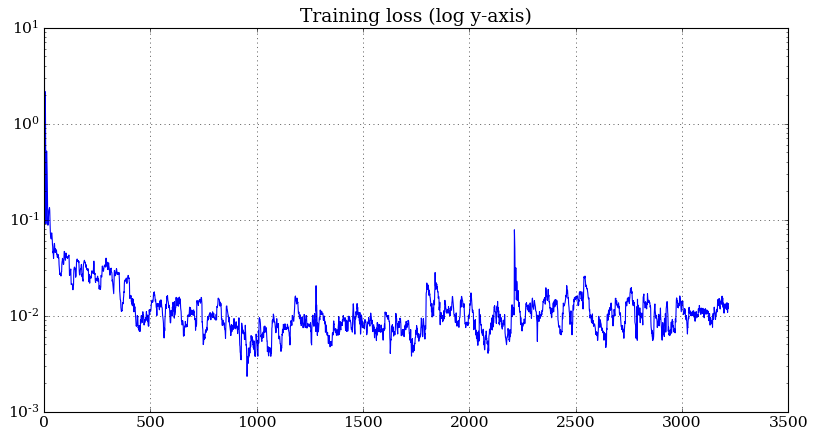

In [178]:
plt.plot(hists.flatten())
plt.gca().set_yscale('log')
plt.title('Training loss (log y-axis)');

## Process predictions

In [63]:
preds.shape

(3219, 25, 2)

In [ ]:
i = 0
plt.plot(preds[i][:,0], label='u')
plt.plot(preds[i][:,1], label='v')

plt.legend()

In [ ]:
plt.plot(df_13s['u'].iloc[i:i+25], label='u')
plt.plot(df_13s['v'].iloc[i:i+25], label='v')
plt.legend()

In [66]:
# Start from index 1 because first sample is not used to predict
df_spd = pd.DataFrame(calc_hspeed(preds[:,:,0], preds[:,:,1]), index=df_13s.index[1:len(preds)+1])
df_dir = pd.DataFrame(calc_dir(preds[:,:,0], preds[:,:,1], offset=280), index=df_13s.index[1:len(preds)+1])

df_u = pd.DataFrame(preds[:,:,0], index=df_13s.index[1:len(preds)+1])
df_v = pd.DataFrame(preds[:,:,1], index=df_13s.index[1:len(preds)+1])

In [86]:
#df_spd.head()
df_spd.shape

(3219, 25)

In [ ]:
df_dir.head()

In [333]:
# Remove first n rows for spinup
n = 10

preds = preds[n:]
pred_scaled = pred_scaled[n:]

df_spd = df_spd.iloc[n:]
df_dir = df_dir.iloc[n:]
df_u = df_u.iloc[n:]
df_v = df_v.iloc[n:]

df_13s = df_13s.iloc[n:]

## Evaluate predictions

In [134]:
i = 5

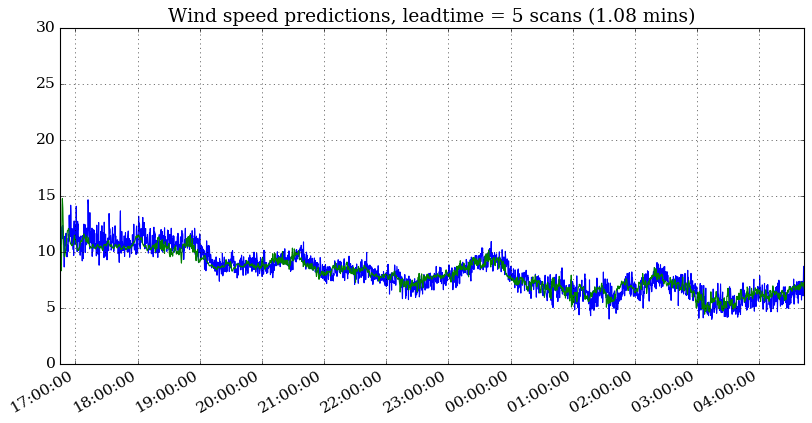

In [135]:
# Scalar wind speed

df_13s.iloc[1:len(preds)+i+1]['wsp'].shift(i).dropna().plot()
df_spd[i].plot()
plt.title('Wind speed predictions, leadtime = ' + str(i) + ' scans (' + str(np.round((i*13)/60,2)) + ' mins)');

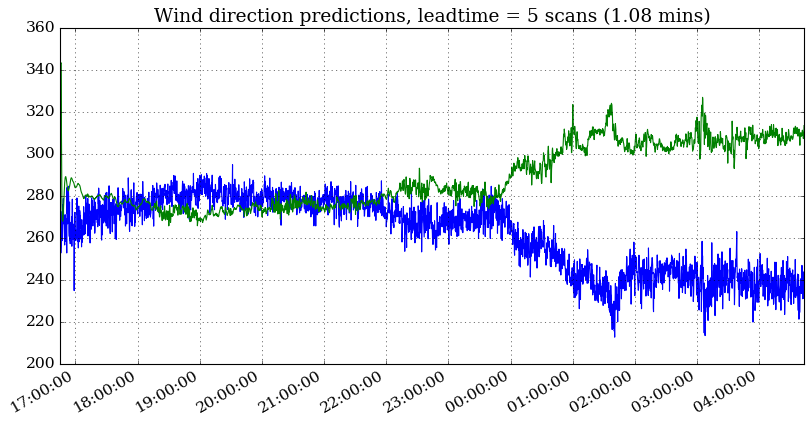

In [136]:
# Wind direction

df_13s.iloc[1:len(preds)+i+1]['wdir'].shift(i).dropna().plot()
df_dir[i].plot()
plt.title('Wind direction predictions, leadtime = ' + str(i) + ' scans (' + str(np.round((i*13)/60,2)) + ' mins)');

In [ ]:
# Find wdir offset
for i in range(0,25):
    print((df_13s.iloc[1:len(preds)+i+1]['wdir'].shift(i).dropna() - df_dir[i]).mean())

In [ ]:
# u-component

df_13s.iloc[1:len(preds)+i+1]['u'].shift(i).dropna().plot()
df_u[i].plot()
plt.title('u-component predictions, leadtime = ' + str(i) + ' scans (' + str(np.round((i*13)/60,2)) + ' mins)');

In [ ]:
# v-component

df_13s.iloc[1:len(preds)+i+1]['v'].shift(i).dropna().plot()
df_v[i].shift(i).dropna().plot()
plt.title('v-component predictions, leadtime = ' + str(i) + ' scans (' + str(np.round((i*13)/60,2)) + ' mins)');

In [ ]:
plot_preds(var=0, shift=2)

In [ ]:
# Interactive applet

interact(plot_preds, 
         var=Dropdown(options=[0, 1, 2, 3], value=0, description='Variable (0=wsp, 1=wdir, 2=u, 3=v'),
         shift=IntSlider(value=1, min=0, max=leads, step=1));

In [ ]:
df_ann_rmse = []

for i in range(0,leads):
    print('--------------------------------------------------------------------')
    print('Lead time = ' + str(i+1) + ' (' + str(np.round(((i+1)*13)/60,2)) + ') mins')
    e = plot_preds(var=0, shift=i)
    df_ann_rmse.append(e)
df_ann_rmse = pd.DataFrame(df_ann_rmse)

In [119]:
df_ann_rmse['t'] = ((df_ann_rmse.index+1) * 13) / 60
df_ann_rmse.set_index(df_ann_rmse['t'], inplace=True)
del df_ann_rmse['t']

In [ ]:
df_ann_rmse.plot(legend=None, marker='.')
plt.title('ANN errors by lead time')
plt.xlabel('Lead time (mins)')
plt.ylabel('RMSE (m/s)');

### ANN & Persistence Comparison

In [ ]:
ax = df_ann_rmse.plot(marker='.')
df_pers_rmse.plot(marker='.', ax=ax)
plt.legend(['ANN', 'Persistence'], loc='upper center', bbox_to_anchor=(1.15, 1),
          ncol=1, fancybox=True, shadow=True)

plt.title('Errors by lead time')
plt.xlabel('Lead time (mins)')
plt.ylabel('RMSE (m/s)');

## Old method (batch fitting, TTS)

In [ ]:
batch_size = 1
epochs = 25
model_hist = model.fit(X_train_scaled, y_train_scaled,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_scaled, y_test_scaled))

In [110]:
preds_scaled = model.predict(X_test_scaled, batch_size=batch_size, verbose=1)

1080/1080 [==============================] - 4s 4ms/step


In [111]:
preds_scaled = preds_scaled.reshape((preds_scaled.shape[0], preds_scaled.shape[2]))
print(preds_scaled.shape)

(1080, 2)


In [112]:
preds = y_test_scaler.inverse_transform(preds_scaled)

In [113]:
# Get scalar wind speed for predictions
preds_ws = np.sqrt((preds[:,0])**2 + (preds[:,1])**2)

In [79]:
np.save('convlstm2d_rs_preds.npy', preds)

In [83]:
save_model(model, 'convlstm2d_rs_model.hdf')

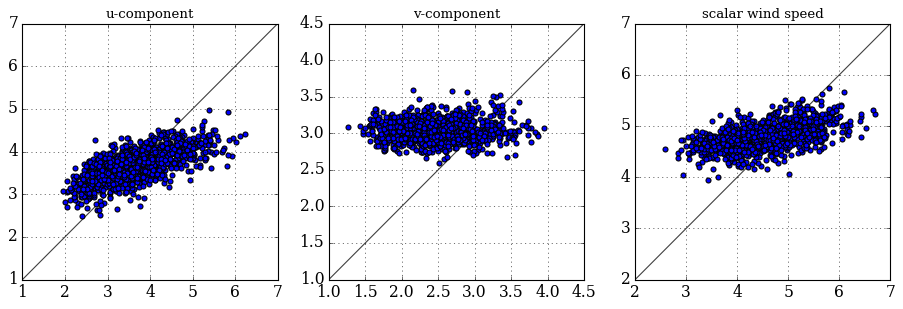

In [114]:
performance_scatter(y_test, y_test_ws, preds, preds_ws)

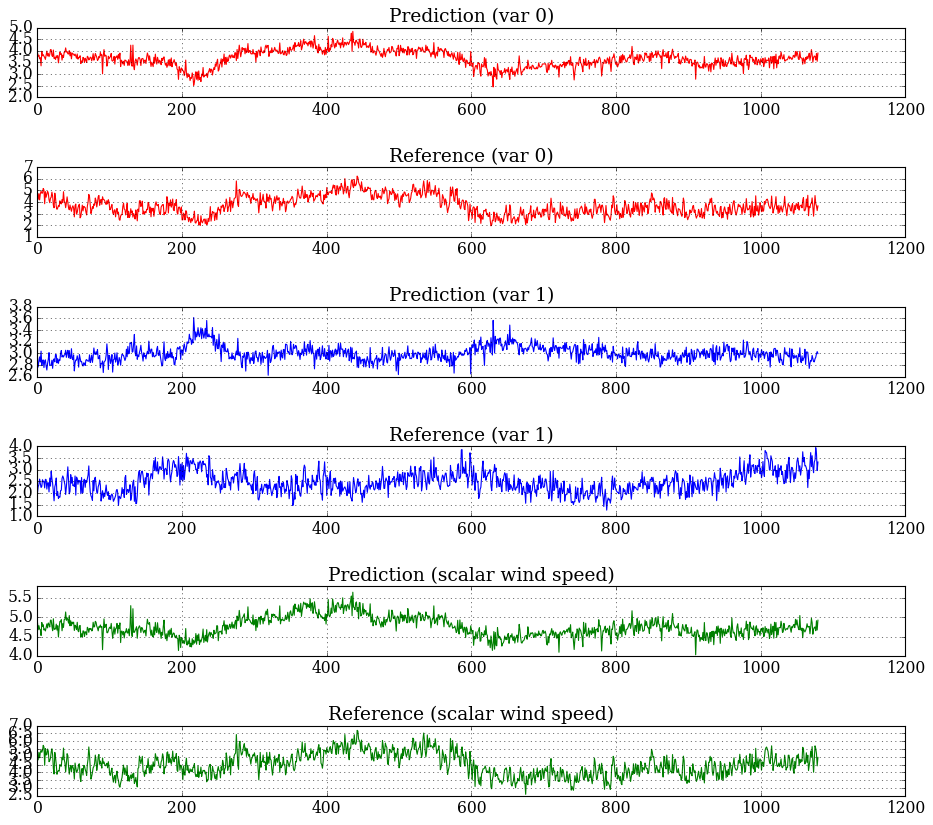

In [85]:
performance_ts(y_test, y_test_ws, preds, preds_ws)

In [86]:
print('VARIABLE 0: U COMPONENT')
print(ols_fit_summary(y_test, preds, var_num=0))
print('-' * 120)
print('VARIABLE 1: V COMPONENT')
print(ols_fit_summary(y_test, preds, var_num=1))
print('-' * 120)
print('SCALAR WIND SPEED')
print(ols_fit_summary(y_test_ws, preds_ws, single_var=True))

VARIABLE 0: U COMPONENT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     1093.
Date:                Fri, 17 Aug 2018   Prob (F-statistic):          4.30e-166
Time:                        15:33:59   Log-Likelihood:                -933.23
No. Observations:                1080   AIC:                             1870.
Df Residuals:                    1078   BIC:                             1880.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0914      0

In [115]:
# Returned as: mae, mse, rmse
print('VARIABLE 0: U COMPONENT')
print(forcast_metrics(x=y_test, y=preds, var_num=0))
print('VARIABLE 1: V COMPONENT')
print(forcast_metrics(x=y_test, y=preds, var_num=1))
print('SCALAR WIND SPEED')
print(forcast_metrics(x=y_test_ws, y=preds_ws, single_var=True))

VARIABLE 0: U COMPONENT
(0.5023594248996905, 0.3856756411126158, 0.6210278907686964)
VARIABLE 1: V COMPONENT
(0.6158805209360009, 0.5247873381241469, 0.724422071809071)
SCALAR WIND SPEED
(0.5641970465806444, 0.47546258557337995, 0.6895379507854371)


# ConvLSTM2D (multi-layer)

In [88]:
print(X_train_scaled.shape)
print(y_train_scaled.shape)

(2190, 1, 201, 394, 1)
(2190, 1, 2)


In [89]:
# Conv LSTM 2D with multi-layers

# Input data in shape (samples, timesteps, y, x, channels (x and y optical flow motion))

model_in = Input(shape=X_train_scaled.shape[1:])
opt = Adam()

# 1st set of layers

model = ConvLSTM2D(16, (5, 5), return_sequences=True, activation='relu', padding='same', kernel_regularizer=l2(l2_a))(model_in)
model = Dropout(0.1)(model)
model = TimeDistributed(MaxPooling2D())(model)
#model = MaxPooling3D()(model)

# 2nd set of layers
model = ConvLSTM2D(32, (5, 5), return_sequences=True, activation='relu', padding='same', kernel_regularizer=l2(l2_a))(model)
model = Dropout(0.1)(model)
model = TimeDistributed(MaxPooling2D())(model)
#model = MaxPooling3D()(model)

# 3rd set of layers
model = ConvLSTM2D(64, (5, 5), return_sequences=True, activation='relu', padding='same', kernel_regularizer=l2(l2_a))(model)
model = Dropout(0.1)(model)
model = TimeDistributed(MaxPooling2D())(model)
#model = MaxPooling3D()(model)


# Shape output and compile
model = TimeDistributed(Flatten())(model)
model = TimeDistributed(Dense(2))(model)
#model = Reshape((15,2), input_shape=(30,))(model)

model = Model(model_in, model)
model.compile(opt, loss='mean_squared_error')

In [90]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1, 201, 394, 1)    0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 201, 394, 16)   27264     
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 201, 394, 16)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 100, 197, 16)   0         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 1, 100, 197, 32)   153728    
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 100, 197, 32)   0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 50, 98, 32)     0         
__________

In [91]:
batch_size = 64
epochs = 25
model_hist = model.fit(X_train_scaled, y_train_scaled,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_scaled, y_test_scaled))

Train on 2190 samples, validate on 1080 samples
Epoch 1/25
2190/2190 [==============================] - 40s 18ms/step - loss: 0.1489 - val_loss: 0.1221
Epoch 2/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0587 - val_loss: 0.1235
Epoch 3/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0437 - val_loss: 0.1501
Epoch 4/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0380 - val_loss: 0.1921
Epoch 5/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0343 - val_loss: 0.2575
Epoch 6/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0339 - val_loss: 0.1699
Epoch 7/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0325 - val_loss: 0.1888
Epoch 8/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0306 - val_loss: 0.1963
Epoch 9/25
2190/2190 [==============================] - 35s 16ms/step - loss: 0.0302 - val_loss: 0.2237
Epoch 10/25
2190

In [93]:
preds_scaled = model.predict(X_test_scaled, batch_size=64, verbose=1)
print(preds_scaled.shape)

1080/1080 [==============================] - 5s 5ms/step


In [96]:
preds_scaled = preds_scaled.reshape((preds_scaled.shape[0], preds_scaled.shape[2]))
print(preds_scaled.shape)

(1080, 2)


In [97]:
preds = y_test_scaler.inverse_transform(preds_scaled)

In [99]:
# Get scalar wind speed for predictions
preds_ws = np.sqrt((preds[:,0])**2 + (preds[:,1])**2)

In [98]:
np.save('convlstm2d_multilayer_rs_preds.npy', preds)

In [100]:
save_model(model, 'convlstm2d_multilayer_rs_model.hdf')

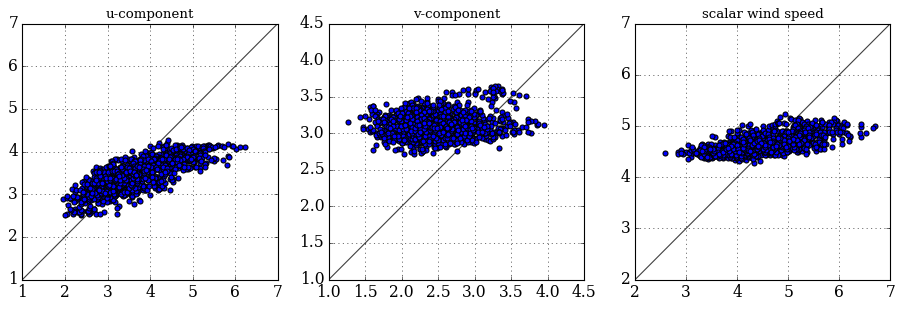

In [101]:
performance_scatter(y_test, y_test_ws, preds, preds_ws)

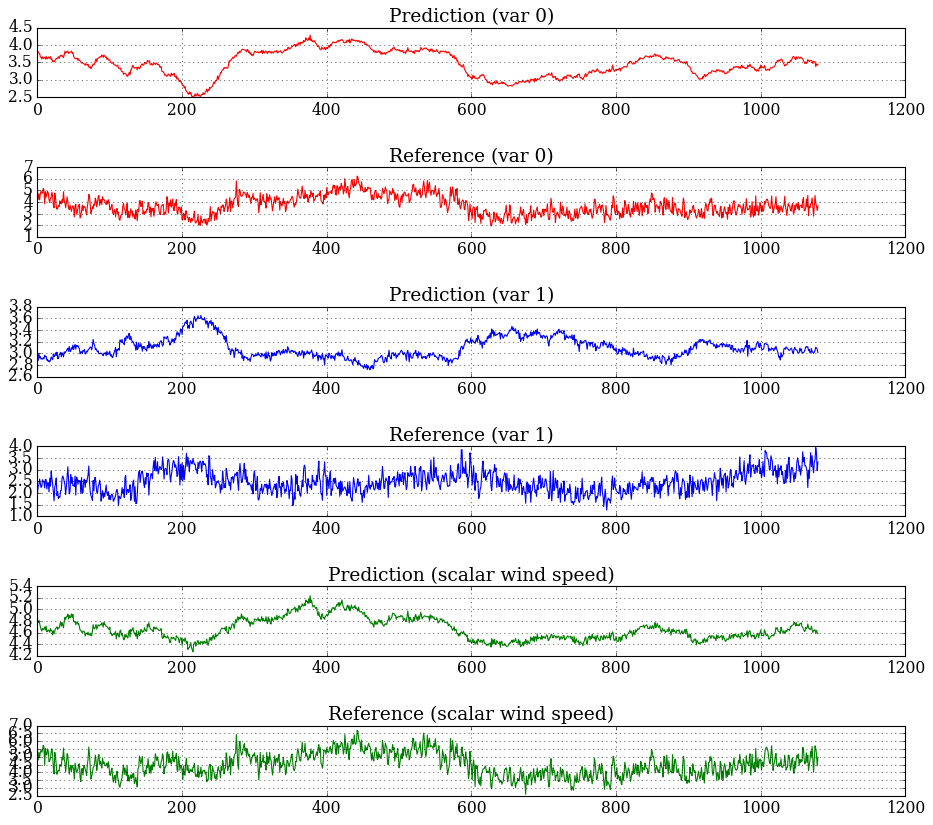

In [102]:
performance_ts(y_test, y_test_ws, preds, preds_ws)

In [103]:
print('VARIABLE 0: U COMPONENT')
print(ols_fit_summary(y_test, preds, var_num=0))
print('-' * 120)
print('VARIABLE 1: V COMPONENT')
print(ols_fit_summary(y_test, preds, var_num=1))
print('-' * 120)
print('SCALAR WIND SPEED')
print(ols_fit_summary(y_test_ws, preds_ws, single_var=True))

VARIABLE 0: U COMPONENT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     1622.
Date:                Fri, 17 Aug 2018   Prob (F-statistic):          3.51e-217
Time:                        15:57:22   Log-Likelihood:                -815.46
No. Observations:                1080   AIC:                             1635.
Df Residuals:                    1078   BIC:                             1645.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1747      0

In [104]:
# Returned as: mae, mse, rmse
print('VARIABLE 0: U COMPONENT')
print(forcast_metrics(x=y_test, y=preds, var_num=0))
print('VARIABLE 1: V COMPONENT')
print(forcast_metrics(x=y_test, y=preds, var_num=1))
print('SCALAR WIND SPEED')
print(forcast_metrics(x=y_test_ws, y=preds_ws, single_var=True))

VARIABLE 0: U COMPONENT
(0.49503413502580357, 0.3943544837345653, 0.6279764993489527)
VARIABLE 1: V COMPONENT
(0.6518328890412641, 0.5839051319725184, 0.7641368542169121)
SCALAR WIND SPEED
(0.5357338747160095, 0.4218925367762743, 0.6495325525147099)


# CNN + LSTM layers

In [0]:
# Next try a combination of Conv2D and LSTM layers?

In [0]:
# Add another axis (here, 5th)
Xx = np.expand_dims(X, 4)

# All results comparison

In [0]:
# Load model predictions from saved files
# Model 1: Conv2D (multi layer set)
p1 =  np.load('cnn_10epoch_preds.npy')
# Model 2: ConvLSTM2D (single layer set)
p2 = np.load('convlstm2d_10epoch_preds.npy')
# Model 3: ConvLSTM2D (multi layer set)
p3 = np.load('convlstm2d_multilayer_10epoch_preds.npy')

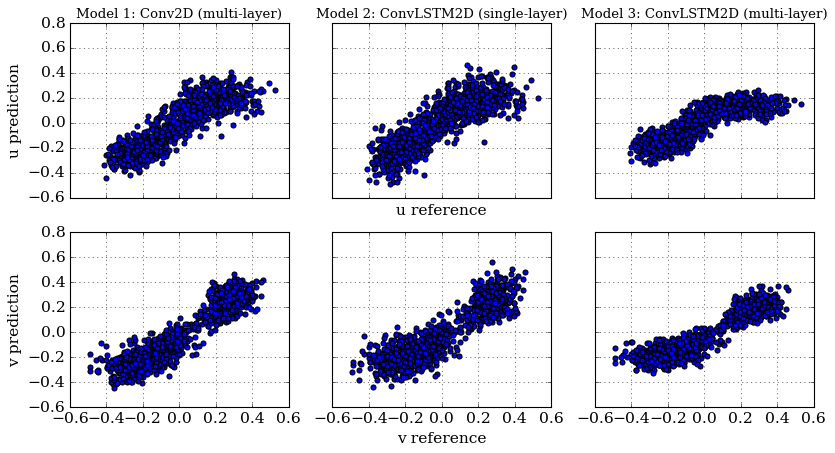

In [0]:
# Model comparison, with both variables together

f, axarr = plt.subplots(2,3, figsize=(12,6), sharex=True, sharey=True)
axarr[0][0].scatter(y_test[:,0], p1[:,0])
axarr[1][0].scatter(y_test[:,1], p1[:,1])
axarr[0][0].set_title('Model 1: Conv2D (multi-layer)', fontsize=12)

axarr[0][1].scatter(y_test[:,0], p2[:,0])
axarr[1][1].scatter(y_test[:,1], p2[:,1])
axarr[0][1].set_title('Model 2: ConvLSTM2D (single-layer)', fontsize=12)

axarr[0][2].scatter(y_test[:,0], p3[:,0])
axarr[1][2].scatter(y_test[:,1], p3[:,1])
axarr[0][2].set_title('Model 3: ConvLSTM2D (multi-layer)', fontsize=12)

axarr[0][1].set_xlabel('u reference')
axarr[1][1].set_xlabel('v reference')
axarr[0][0].set_ylabel('u prediction')
axarr[1][0].set_ylabel('v prediction')

plt.savefig('keras_model_comparison.png')

# Stateful prediction ahead (timesteps) 

In [0]:
# First check if y has any NaN values
# This would cause issues when shifting
np.isnan(y).any()

False

In [0]:
# Add new axis with lagged values
window_size = 100
# 100 = 21.6 mins

y[:,np.newaxis,:].shape

(3270, 1, 2)

In [0]:
print(y.shape)

(3270, 2)


In [0]:
# TTS needs to happen after new timestep dimensions
# Split up train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

(1080, 2)

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2190, 201, 394, 2)
(1080, 201, 394, 2)
(2190, 2)
(1080, 2)
